In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from collections import Counter
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

### Import Data

In [2]:
df = pd.read_csv("data/creditcard.csv")
print("df shape:", df.shape)
df.head()

df shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Explore Data

In [3]:
labels=["Genuine","Fraud"]
fraud_or_not = df["Class"].value_counts()
fig = px.pie(values=fraud_or_not, names=labels , width=700, height=400, color_discrete_sequence=["skyblue","gray"]
             ,title="Fraud vs Genuine transactions")
fig.show()

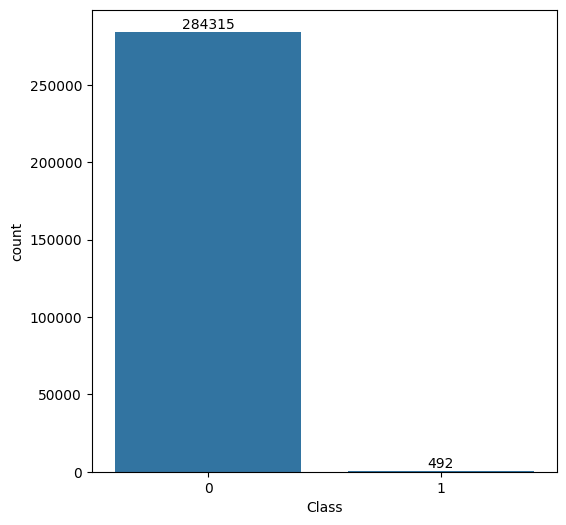

In [4]:
plt.figure(figsize=(6, 6))
ax = sns.countplot(x="Class", data=df)
ax.bar_label(ax.containers[0]);

#### Dropping duplicated values

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df = df.drop('Time', axis=1)

#### Analysis Outlier Data

In [7]:
numeric_columns = list(df.loc[:, "V1":"Amount"])

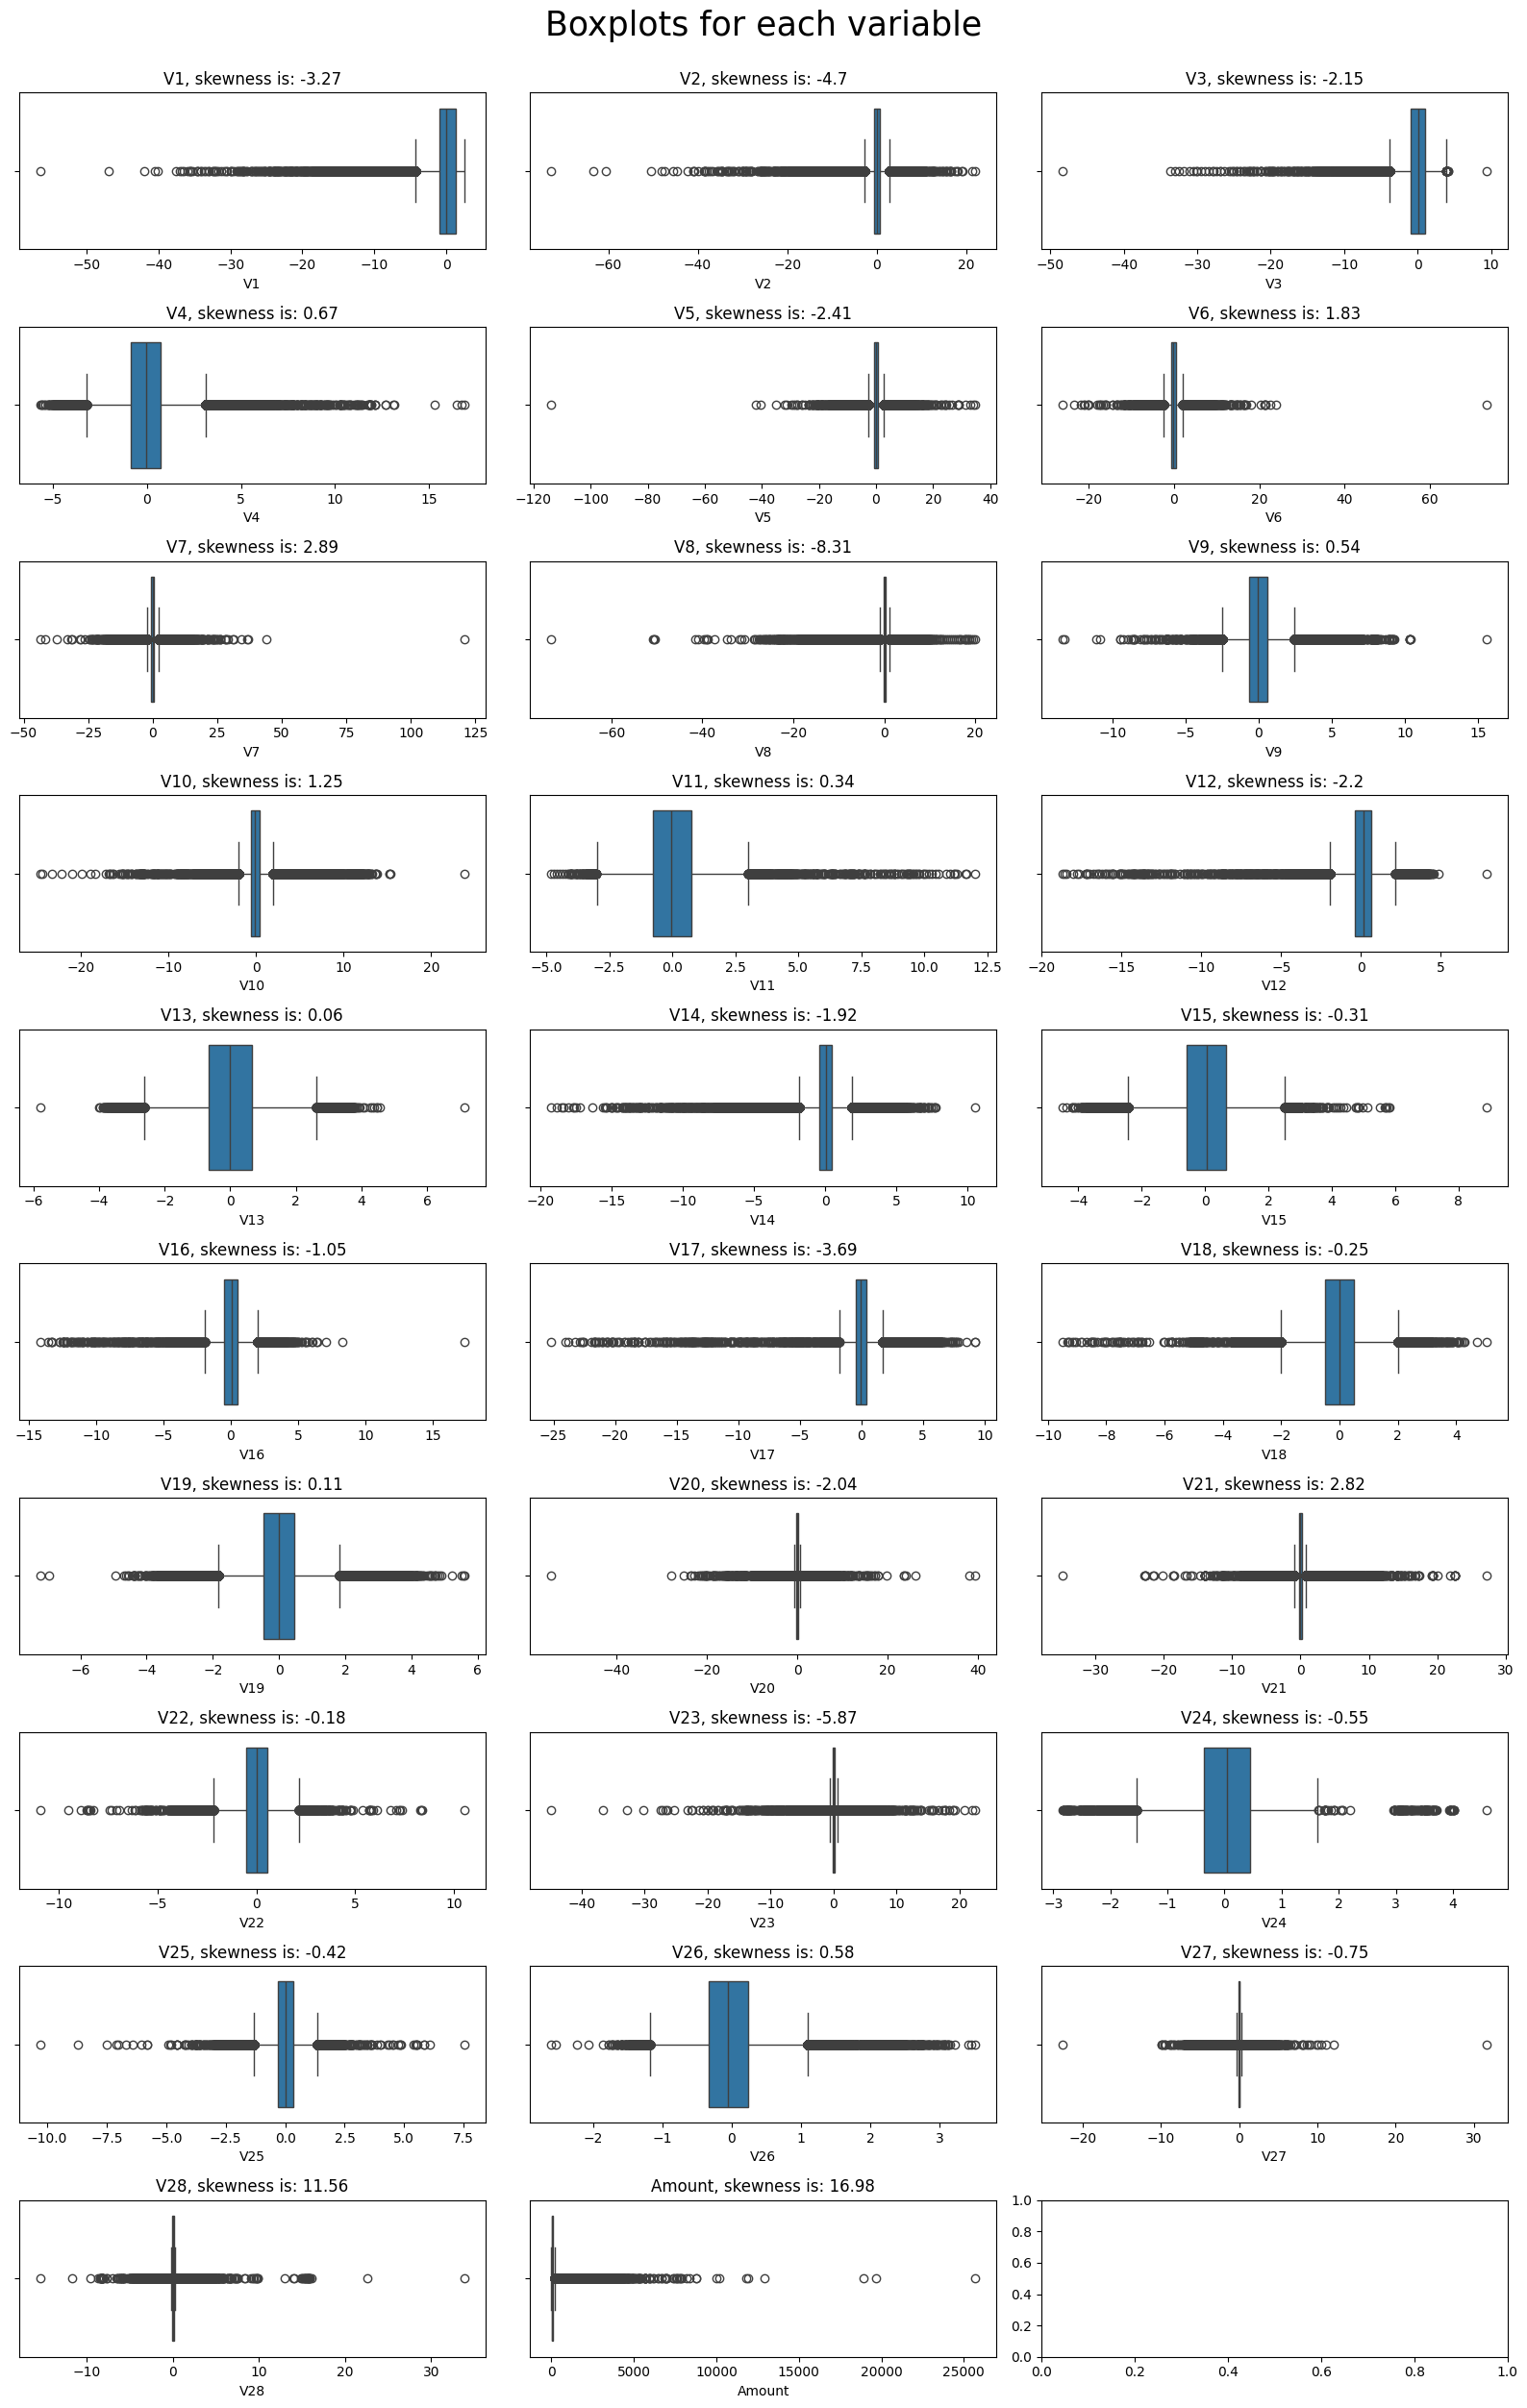

In [48]:
def boxplots_cols(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, figsize=(16,25))
    fig.suptitle(suptitle, y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient="h", ax=axs[i])
        axs[i].set_title(data + ", skewness is: " + str(round(dataset[data].skew(axis=0, skipna=True), 2)))
        

boxplots_cols(dataset=df, columns_list=numeric_columns, rows=10, cols=3, suptitle="Boxplots for each variable")
plt.tight_layout() 

#### Inter Quartile Range (IQR)

In [9]:
def iqr_method(df, features):
    outlier_list = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_column = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_list.extend(outlier_list_column)
    outlier_list = Counter(outlier_list)
    multiple_outlier = list(k for k,v in outlier_list.items() if v > 1)
    return multiple_outlier

In [10]:
outliers_IQR = iqr_method(df, numeric_columns)
df_out = df.drop(outliers_IQR, axis=0).reset_index()

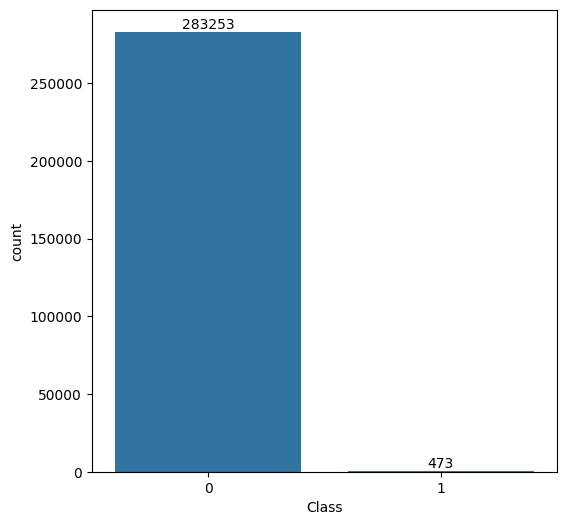

In [11]:
plt.figure(figsize=(6, 6))
ax = sns.countplot(x="Class", data=df)
ax.bar_label(ax.containers[0]);

### Split

In [17]:
target = "Class"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (283726, 29)
y shape: (283726,)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (226980, 29)
y_train shape: (226980,)
X_test shape: (56746, 29)
y_test shape: (56746,)


#### Resample

In [23]:
over_sample = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sample.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)

X_train_over shape: (453194, 29)


### Build model

#### Baseline

In [25]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9983


In [28]:
clf = make_pipeline(
    SimpleImputer(), RandomForestClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [29]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores)

[0.99995587 0.99998897 0.99994484 0.9999669  0.99994484]


In [30]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 50, 10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [32]:
model = GridSearchCV(
    clf, param_grid=params, cv=5, n_jobs=-1, verbose=1
)

In [33]:
# Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [34]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,43.845059,0.266286,0.322299,0.044819,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.993513,0.995719,0.994451,0.994815,0.994439,0.994587,0.000711,21
1,46.044500,0.851870,0.297864,0.057950,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.993513,0.995719,0.994451,0.994815,0.994439,0.994587,0.000711,21
2,88.222732,1.736169,0.416210,0.028864,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.993391,0.995863,0.994506,0.994848,0.993457,0.994413,0.000923,23
3,89.488228,0.786374,0.439098,0.045089,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.993391,0.995863,0.994506,0.994848,0.993457,0.994413,0.000923,23
4,126.180825,1.864698,0.530022,0.013360,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.995918,0.995896,0.995896,0.994837,0.994517,0.995413,0.000609,19
5,126.065604,1.144214,0.548686,0.030577,10,75,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.995918,0.995896,0.995896,0.994837,0.994517,0.995413,0.000609,19
6,46.909393,1.021481,0.290927,0.030068,20,25,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.999934,0.999967,0.999923,0.999967,0.999923,0.999943,0.000020,17
7,49.406027,0.727184,0.286154,0.011240,20,25,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.999934,0.999967,0.999923,0.999967,0.999923,0.999943,0.000020,17
8,95.397056,1.430644,0.500246,0.036628,20,50,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.999934,0.999978,0.999945,0.999967,0.999923,0.999949,0.000020,13
9,96.979495,1.510469,0.533458,0.072826,20,50,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.999934,0.999978,0.999945,0.999967,0.999923,0.999949,0.000020,13


In [35]:
# Extract best hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__n_estimators': 75,
 'simpleimputer__strategy': 'mean'}

### Evaluate

In [36]:
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9995


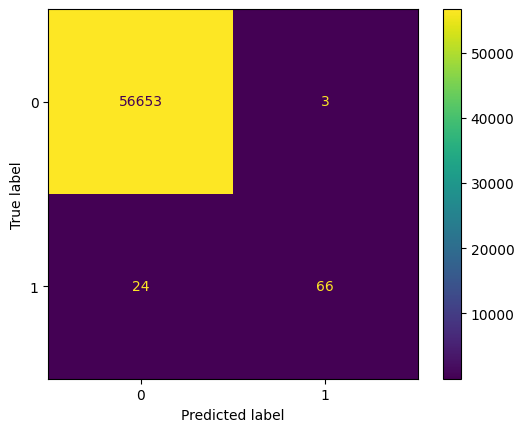

In [40]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

In [41]:
# Print classification report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.96      0.73      0.83        90

    accuracy                           1.00     56746
   macro avg       0.98      0.87      0.91     56746
weighted avg       1.00      1.00      1.00     56746



### Communicate

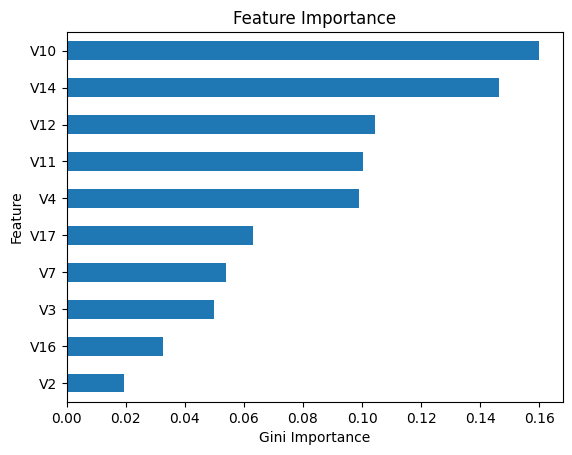

In [42]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [44]:
# Save model
with open("randomforest_model.pkl", "wb") as f:
    pickle.dump(model, f)